# Foundations of Data Science
## Homework 4 

Student Name: Akshay Prakash Tambe

Student Netid: apt321
***

In this assignment we will be looking at data generated by particle physicists to test whether machine learning can help classify whether certain particle decay experiments identify the presence of a Higgs Boson. One does not need to know anything about particle physics to do well here, but if you are curious, full feature and data descriptions can be found here:

- https://www.kaggle.com/c/higgs-boson/data
- http://higgsml.lal.in2p3.fr/files/2014/04/documentation_v1.8.pdf

The goal of this assignment is to learn to use cross-validation for model selection as well as bootstrapping for error estimation. We’ll also use learning curve analysis to understand how well different algorithms make use of limited data. For more documentation on cross-validation with Python, you can consult the following:

- http://scikit-learn.org/stable/modules/cross_validation.html#cross-validation


### Part 1: Data preparation (5 points)
Create a data preparation and cleaning function that does the following:
- Has a single input that is a file name string
- Reads data (the data is comma separated, has a row header and the first column `EventID` is the index) into a pandas `dataframe`
- Cleans the data
  - Convert the feature `Label` to numeric (choose the minority class to be equal to 1)
    - Create a feature `Y` with numeric label
    - Drop the feature `Label`
  - If a feature has missing values (i.e., `-999`): 
    - Create a dummy variable for the missing value
      - Call the variable `orig_var_name` + `_mv` where `orig_var_name` is the name of the actual var with a missing value
      - Give this new variable a 1 if the original variable is missing
    - Replace the missing value with the average of the feature (make sure to compute the mean on records where the value isn't missing). You may find pandas' `.replace()` function useful.
- After the above is done, rescales the data so that each feature has zero mean and unit variance (hint: look up sklearn.preprocessing)
- Returns the cleaned and rescaled dataset

Hint: as a guide, this function can easily be done in less than 15 lines.

In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing

# cleanBosonData has a single input parameter,i.e., a file name string
def cleanBosonData(infile_name):
    # Read CSV File in Pandas DataFrame, First Row as Header and First Column EventID as index
    data_clean = pd.read_csv(infile_name, header=0, index_col=0)
    
    # Count of each label from the dataframe (Using Dictionary for efficient search and storage)
    label_value_counts = dict(data_clean['Label'].value_counts())
    
    # Identifying Minority Class (Least Value Label Count)
    minority_class = min(label_value_counts, key=label_value_counts.get)
    
    # Convert the feature Label to numeric (choose the minority class to be equal to 1)
    # Create a feature Y with numeric label
    data_clean['Y'] = np.where(data_clean.Label == minority_class,1,0)
    # Drop the feature Label
    data_clean = data_clean.drop('Label', axis=1)
    
    # Checking for Missing Values
    for feature in data_clean.columns:
        # Feature has missing values (i.e., -999)
        if any(data_clean[feature] == -999):
            # Call the variable orig_var_name + _mv where orig_var_name is the name of the actual var with a missing value
            # Give this new variable a 1 if the original variable is missing
            data_clean[feature + '_mv'] = np.where(data_clean[feature] == -999, 1, 0)
            # Replace -999 values with nan, so that -999 values don't affect mean
            data_clean[feature] = data_clean[feature].replace(-999, np.nan)
            # Replace the missing value with the average of the feature
            data_clean[feature] = data_clean[feature].replace(np.nan, data_clean[feature].mean())
        
        # Rescale the data so that each feature has zero mean and unit variance
        if feature != 'Y':
            data_clean[feature] = preprocessing.scale(data_clean[feature])
            
    return data_clean

### Part 2: Basic evaluations (5 points)
In this part you will build an out-of-the box logistic regression (LR) model and support vector machine (SVM). You will then plot ROC for the LR and SVM model.

1\. Clean the two data files for this assignment (`boson_training_cut_2000.csv` and `boson_testing_cut.csv`) and use them as training and testing data sets.

In [2]:
data_train = cleanBosonData("boson_training_cut_2000.csv")
data_test = cleanBosonData("boson_testing_cut.csv")

2\. On the training set, build the following models:

- A logistic regression using sklearn's `linear_model.LogisticRegression()`. For this model, use `C=1e30`.
- An SVM using sklearn's `svm.svc()`. For this model, specify that `kernel="linear"`.

For each model above, plot the ROC curve of both models on the same plot. Make sure to use the test set for computing and plotting. In the legend, also print out the Area Under the ROC (AUC) for reference.

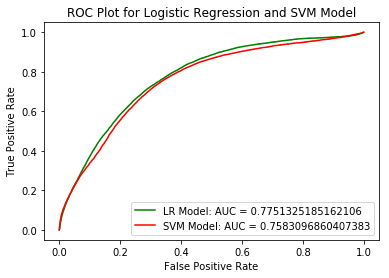

In [3]:
import matplotlib
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn import svm
from sklearn.metrics import roc_curve, auc


# Logistic Regression Model (C=1e30)
logistic_regression_model = linear_model.LogisticRegression(C=1e30)
logistic_regression_model.fit(data_train.drop('Y', axis=1), data_train['Y'])

# Predicting Labels, Calculating FPR, TPR, Thresholds and ROC Value using Logistic Regression Model
predictions = logistic_regression_model.decision_function(data_test.drop('Y', axis=1))
logreg_fpr, logreg_tpr, thresholds = roc_curve(data_test['Y'], predictions)
logreg_roc = auc(logreg_fpr, logreg_tpr)

# SVM Model (kernel="linear")
svm_model = svm.SVC(kernel='linear')
svm_model.fit(data_train.drop('Y', axis=1), data_train['Y'])

# Predicting Labels, Calculating FPR, TPR, Thresholds and ROC Value using SVM Model
predictions = svm_model.decision_function(data_test.drop('Y', axis=1))
svm_fpr, svm_tpr, thresholds = roc_curve(data_test['Y'], predictions)
svm_roc = auc(svm_fpr, svm_tpr)

# Plotting the ROC curve for both models on the same plot
plt.title('ROC Plot for Logistic Regression and SVM Model')
plt.plot(logreg_fpr, logreg_tpr, 'g', label='LR Model: AUC = ' + str(logreg_roc))
plt.plot(svm_fpr, svm_tpr, 'r', label='SVM Model: AUC = ' + str(svm_roc))
plt.legend(loc='lower right')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

3\. Which of the two models is generally better at ranking the test set? Are there any classification thresholds where the model identified above as "better" would underperform the other in a classification metric (such as TPR)?

The Logistic Regression Linear model is better at ranking the test set than the SVM Model by comparing their AUC scores.  
The SVM Model performs better at around tpr=0.2 and fpr=0.05 and here, logistic regression linear model underperforms as compared to SVM Model.

### Part 3: Model selection with cross-validation (10 points)
We think we might be able to improve the performance of the SVM if we perform a grid search on the hyper-parameter $C$.  Because we only have 1000 instances, we will have to use cross-validation to find the optimal $C$.

1\. Write a cross-validation function that does the following:
- Takes as inputs a dataset, a label name, # of splits/folds (`k`), a sequence of values for $C$ (`cs`)
- Performs two loops
  - Outer Loop: `for each f in range(k)`:
    - Splits the data into `data_train` & `data_validate` according to cross-validation logic
  - Inner Loop: `for each c in cs`:
    - Trains an SVM on training split with `C=c, kernel="linear"`
    - Computes AUC_c_k on validation data
    - Stores AUC_c_k in a  dictionary of values
- Returns a dictionary, where each key-value pair is: `c:[auc-c1,auc-c2,..auc-ck]`

In [4]:
from sklearn.model_selection import KFold

# Takes as inputs a dataset, a label name, # of splits/folds (k), a sequence of values for  CC  (cs)
def xValSVM(dataset, label_name, k, cs):

    # Removing Target Variable from dataset and storing it seperately
    data = dataset.drop(label_name, axis=1)
    target = dataset[label_name]
    aucs = {}
    
    for f in range(2,k):
        cross_val = KFold(n_splits = f)
        
        # Split the data into data_train & data_validate 
        for data_train_index, data_validate_index in cross_val.split(X=data, y=target):
            data_train = dataset.iloc[data_train_index]
            data_validate = dataset.iloc[data_validate_index]
            
            for c in cs:
                # Train SVM on training split with C=c, kernel="linear"
                svm_model = svm.SVC(kernel='linear', C=c)
                # Fit the Model
                svm_model.fit(data_train.drop(label_name, axis=1),data_train[label_name])
                # Predicting Labels, Calculating FPR, TPR, Thresholds and ROC Value using SVM Model
                predictions = svm_model.decision_function(data_validate.drop(label_name, axis=1))
                fpr, tpr, thresholds = roc_curve(data_validate[label_name], predictions)
                # Computes AUC_c_k on validation data
                AUC_c_k = auc(fpr, tpr)
                
                # Stores AUC_c_k in a dictionary of values
                if c in aucs:
                    aucs[c].append(AUC_c_k)
                else:
                    aucs[c] = [AUC_c_k]
    
    # Returns a dictionary, where each key-value pair is: c:[auc-c1,auc-c2,..auc-ck]
    return aucs

2\. Using the function written above, do the following:
- Generate a sequence of 10 $C$ values in the interval `[10^(-8), ..., 10^1]` (i.e., do all powers of 10 from -8 to 1).
2.	Call aucs = xValSVM(train, ‘Y’, 10, cs)
3.	For each c in cs, get mean(AUC) and StdErr(AUC) 
4.	Compute the value for max(meanAUC-StdErr(AUC)) across all values of c.
5.	Generate a plot with the following:
a.	Log10(c) on the x-axis
b.	1 series with mean(AUC) for each c
c.	1 series with mean(AUC)-stderr(AUC) for each c (use ‘k+’ as color pattern)
d.	1 series with mean(AUC)+stderr(AUC) for each c (use ‘k--‘ as color pattern)
e.	a reference line for max(AUC-StdErr(AUC)) (use ‘r’ as color pattern)

Then answer the question: Did the model parameters selected beat the out-of-the-box model for SVM? 

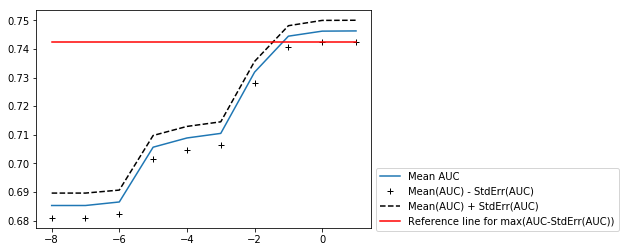

Max AUC achieved =  0.7903552236722731


In [5]:
# Generate a sequence of 10C  values in the interval [10^(-8), ..., 10^1] (i.e., do all powers of 10 from -8 to 1).
cs = [10**i for i in range(-8,2)]

# Cross-Validation
aucs = xValSVM(data_train, 'Y', 10 , cs)

# For each c in cs, get mean(AUC) and StdErr(AUC)
mean = []
stderr = []
for c in cs:
    mean.append(np.mean(aucs[c]))
    stderr.append(np.sqrt(np.var(aucs[c])/((len(aucs[c])))))

# Compute the value for max(meanAUC-StdErr(AUC)) across all values of c.
reference_line_value = np.ones(len(mean))*(max(np.array(mean) - np.array(stderr)))

# Plotting series with mean(AUC) for each c
plt.plot(np.log10(cs), np.array(mean), label='Mean AUC')

# Plotting series with mean(AUC)-stderr(AUC) for each c (use ‘k+’ as color pattern)
plt.plot(np.log10(cs), np.array(mean)-np.array(stderr), 'k+', label='Mean(AUC) - StdErr(AUC)')

# Plotting series with mean(AUC)+stderr(AUC) for each c (use ‘k--‘ as color pattern)
plt.plot(np.log10(cs), np.array(mean)+np.array(stderr), 'k--', label='Mean(AUC) + StdErr(AUC)')

# Plotting a reference line for max(AUC-StdErr(AUC)) (use ‘r’ as color pattern)
plt.plot(np.log10(cs), reference_line_value, 'r', label='Reference line for max(AUC-StdErr(AUC))')

plt.legend(bbox_to_anchor = (1, 0.30))
plt.show()

print("Max AUC achieved = ", pd.DataFrame(aucs).max().max())

Yes, the model parameters selected beat the out-of-the-box model for SVM Model.  
From the observations in the graph, we can see that "Mean AUC" value is less than our initial previous observed AUC value.  
However, after doing further checks in the dictionary which gives AUC for each c value, we got a max AUC Score of 0.79 which is higher than our initial previous observed AUC value. 

### Part 4: Learning Curve with Bootstrapping
In this HW we are trying to find the best linear model to predict if a record represents the Higgs Boson. One of the drivers of the performance of a model is the sample size of the training set.  As a data scientist, sometimes you have to decide if you have enough data or if you should invest in more.  We can use learning curve analysis to determine if we have reached a performance plateau. This will inform us on whether or not we should invest in more data (in this case it would be by running more experiments).

Given a training set of size $N$, we test the performance of a model trained on a subsample of size $N_i$, where $N_i<=N$.  We can plot how performance grows as we move $N_i$ from $0$ to $N$.  

Because of the inherent randomness of subsamples of size $N_i$, we should expect that any single sample of size $N_i$ might not be representative of an algorithm’s performance at a given training set size. To quantify this variance and get a better generalization, we will also use bootstrap analysis. In bootstrap analysis, we pull multiple samples of size $N_i$, build a model, evaluate on a test set, and then take an average and standard error of the results.




1\. Create a bootstrap function that can do the following:

def modBootstrapper(train, test, nruns, sampsize, lr, c):

-	Takes as input:
    -	A master training file (train)
    -	A master testing file (test)
    -	Number of bootstrap iterations (nruns) 
    -	Size of a bootstrap sample (sampsize)
    -	An indicator variable to specific LR or SVM (lr=1)
    -	A c option (only applicable to SVM)

-	Runs a loop with (nruns) iterations, and within each loop:
    -	Sample (sampsize) instances from train, with replacement
    -	Fit either an SVM or LR (depending on options specified). For SVM, use the value of C identified using the 1 standard error method from part 3.    
    -	Computes AUC on test data using predictions from model in above step
    -	Stores the AUC in a list

-	Returns the mean(AUC) and Standard Error(mean(AUC)) across all bootstrap samples


In [6]:
from sklearn.metrics import roc_auc_score
import math
import statistics

def modBootstrapper(train, test, nruns, sampsize, lr, c):
    aucs = []
    
    for i in range(nruns):
        # Sample (sampsize) instances from train, with replacement
        sample_train = train.iloc[np.random.randint(0, len(train), size=sampsize)]
        
        # Fit either an SVM or LR (depending on options specified: If lr==1 --> Fit LR, else SVM)
        if (lr == 1):
            # Logistic Regression Model (C=1e30)
            logistic_regression_model = linear_model.LogisticRegression(C=1e30)
            logistic_regression_model.fit(sample_train.drop('Y', axis=1), sample_train['Y'])
            prediction = logistic_regression_model.predict_proba(test.drop('Y',1))[:,1]
        else:
            # SVM Model (kernel="linear")
            svm_model = svm.SVC(kernel='linear', C=c)
            svm_model.fit(sample_train.drop('Y', axis=1), sample_train['Y'])
            prediction = svm_model.decision_function(test.drop('Y', axis=1))
        
        # Compute AUC on test data using predictions from model and store the AUC in a list
        aucs.append(roc_auc_score(test['Y'], prediction))
    
    # Return the mean(AUC) and Standard Error(mean(AUC)) across all bootstrap samples
    return np.mean(aucs), math.sqrt(statistics.variance(aucs)/nruns)

2\. For both LR and SVM, run 20 bootstrap samples for each samplesize in the following list: samplesizes = [50, 100, 200, 500, 1000, 1500, 2000]. (Note, this might take 10-15 mins … feel free to go grab a drink or watch Youtube while this runs).

Generate a plot with the following:
-	Log2(samplesize) on the x-axis
-	2 sets of results lines, one for LR and one for SVM, the set should include
    -	1 series with mean(AUC) for each sampsize (use the color options ‘g’ for svm, ‘r’ for lr)
    -	1 series with mean(AUC)-stderr(AUC) for each c (use ‘+’ as color pattern, ‘g’,’r’ for SVM, LR respectively)
    -	1 series with mean(AUC)+stderr(AUC) for each c (use ‘--‘ as color pattern ‘g’,’r’ for SVM, LR respectively)


In [7]:
data_train = cleanBosonData("boson_training_cut_2000.csv")
data_test = cleanBosonData("boson_testing_cut.csv")

samplesizes = [50, 100, 200, 500, 1000, 1500, 2000]

# Initializing variables
lr_model_mean = []
lr_model_std_error = []
svm_model_mean = []
svm_model_std_error = []

for samplesize in samplesizes:
    # LR Model (lr = 1)
    mean, std_error = modBootstrapper(data_train, data_test, 20, samplesize, 1, 100)
    lr_model_mean.append(mean)
    lr_model_std_error.append(std_error)
    
    # SVM Model (lr = 0)
    mean, std_error = modBootstrapper(data_train, data_test, 20, samplesize, 0, 100)
    svm_model_mean.append(mean)
    svm_model_std_error.append(std_error)

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/base.py:340: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)


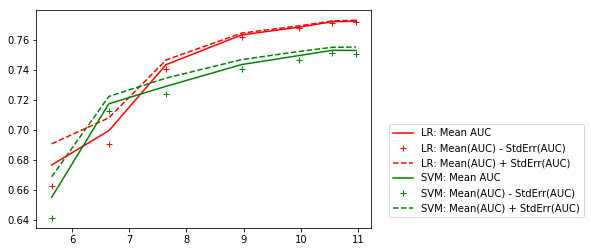

In [8]:
# Plotting for LR Model
# Plotting series with mean(AUC) for each sampsize
plt.plot(np.log2(samplesizes), np.array(lr_model_mean), 'r', label='LR: Mean AUC')
# Plotting series with mean(AUC)-stderr(AUC) for each c
plt.plot(np.log2(samplesizes), np.array(lr_model_mean)-np.array(lr_model_std_error), 'r+', label='LR: Mean(AUC) - StdErr(AUC)')
# Plotting series with mean(AUC)+stderr(AUC) for each c
plt.plot(np.log2(samplesizes), np.array(lr_model_mean)+np.array(lr_model_std_error), 'r--', label='LR: Mean(AUC) + StdErr(AUC)')

# Plotting for SVM Model
# Plotting series with mean(AUC) for each sampsize
plt.plot(np.log2(samplesizes), np.array(svm_model_mean), 'g', label='SVM: Mean AUC')
# Plotting series with mean(AUC)-stderr(AUC) for each c
plt.plot(np.log2(samplesizes), np.array(svm_model_mean)-np.array(svm_model_std_error), 'g+', label='SVM: Mean(AUC) - StdErr(AUC)')
# Plotting series with mean(AUC)+stderr(AUC) for each c
plt.plot(np.log2(samplesizes), np.array(svm_model_mean)+np.array(svm_model_std_error), 'g--', label='SVM: Mean(AUC) + StdErr(AUC)')

plt.legend(bbox_to_anchor = (1.65, 0.5))
plt.show()

3\. Which of the two algorithms are more suitable for smaller sample sizes, given the set of features? If it costs twice the investment to run enough experiments to double the data, do you think it is a worthy investment?


Given the set of the features and results obtained from the above plot, we can say that SVM is better suitable for smaller sample sizes.  

As we can see from the above plot, as the data increases LR performs better than SVM. So SVM is better for small data but overall LR outperforms in large dataset.  

If it costs twice the investment to run enough experiments to double the data, it is not worthy investment as we can see that for the larger samples, both LR and SVM are reaching plateaus and won't affect much increase in AUC beyond the above plot.

4\. Is there a reason why cross-validation might be biased? If so, in what direction is it biased?



Cross-validation may be biased because in k-fold cross-validation we partition the dataset into k-equally sized non-overlapping subsets. Then, for each fold, a model is trained, which is then evaluated on test fold dataset.  

Generally, k-fold cross-validation is biased for lower values of k.(Scenario of 1st fold to be all 1's and 2nd fold to be all 0's). As the k-value increases, bias decreases but variance increases. Hence, there is a bias-variance tradeoff.  

From our analysis of the dataset, better results are obtained when k=10 which is a tradeoff value between bias and variance. Therefore, bias is in decreasing direction as k increases in our dataset.